<a href="https://colab.research.google.com/github/donghyuun/deep-learning/blob/main/univariate_tft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


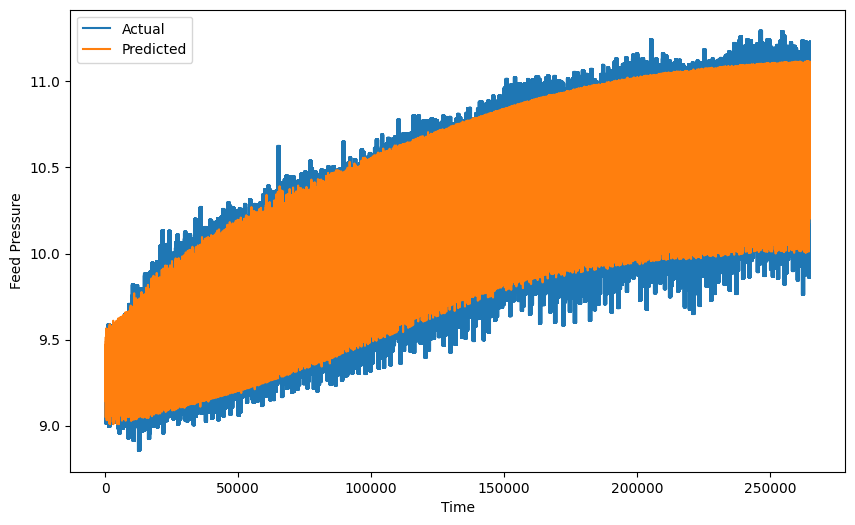

Root Mean Squared Error (RMSE): 0.21054238
R^2 (Coefficient of Determination): 0.8371351957321167
Mean Absolute Percentage Error (MAPE): 1.4750772155821323 %


In [ ]:
# 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib pytorch-lightning pytorch-forecasting

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from torch.optim import Adam
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

# TimeSeriesDataSet 정의
max_encoder_length = 60  # 입력 시퀀스 길이
max_prediction_length = 30  # 예측 시퀀스 길이

# 그룹 ID를 "time_idx" 대신 고유한 그룹으로 설정
df_total["group"] = "series"  # 단일 시계열일 경우 고유 그룹 지정

training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID를 "time_idx"에서 "group"으로 변경
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화를 알 수 있는 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 학습 및 검증 데이터셋 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=RMSE()
)

from torch.optim import Adam

# TFT 모델을 LightningModule로 감싸기 위한 클래스 정의
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]  # `y_hat`에서 첫 번째 요소만 가져오기
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]  # `y_hat`에서 첫 번째 요소만 가져오기
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

# TFT 모델을 TFTWrapper로 감싸기
wrapped_tft = TFTWrapper(tft)

# Trainer 설정
trainer = Trainer(
    accelerator="cpu",  # GPU가 없을 경우 CPU로 설정
    devices=1,
    max_epochs=20,
    gradient_clip_val=0.1
)

# 학습 실행
trainer.fit(
    model=wrapped_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)
# 예측 (변수 하나로 받기)
predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# 필요한 값 추출
raw_predictions = predictions[0]  # 첫 번째 반환 값은 raw_predictions
x = predictions[1]                # 두 번째 반환 값은 x

# 예측값 복원
predicted = scaler.inverse_transform(raw_predictions["prediction"][:, :, 0].cpu().numpy())
actual = scaler.inverse_transform(x["decoder_target"].cpu().numpy())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(actual.flatten(), label="Actual")
plt.plot(predicted.flatten(), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
r2 = r2_score(actual.flatten(), predicted.flatten())
mape = mean_absolute_percentage_error(actual.flatten(), predicted.flatten()) * 100

print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


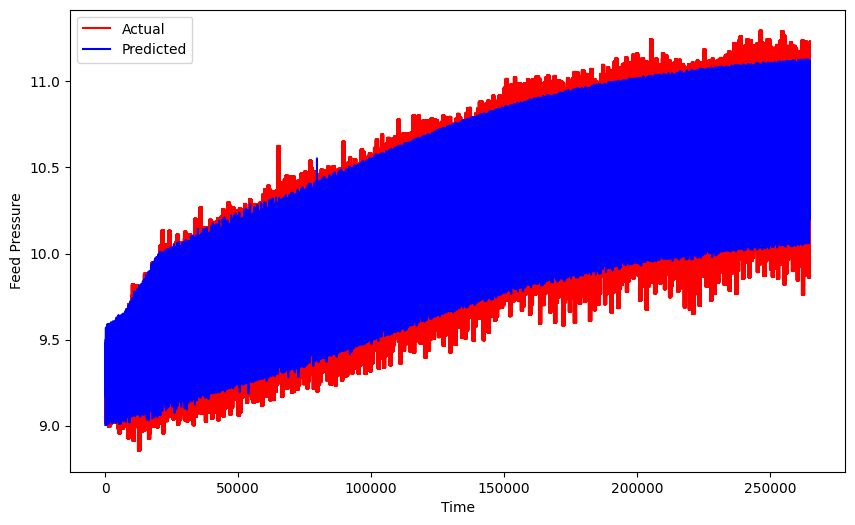

Root Mean Squared Error (RMSE): 0.20818616
R^2 (Coefficient of Determination): 0.8407601118087769
Mean Absolute Percentage Error (MAPE): 1.4381409622728825 %
Pearson Correlation Coefficient (PCC): 0.9174407399300051
Mean Bias Deviation (MBD): 0.012235337
Mean Absolute Error of Means (MAEM): 0.0122356415


In [ ]:
# 예측 (변수 하나로 받기)
predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# 필요한 값 추출
raw_predictions = predictions[0]  # 첫 번째 반환 값은 raw_predictions
x = predictions[1]                # 두 번째 반환 값은 x

# 예측값 복원
predicted = scaler.inverse_transform(raw_predictions["prediction"][:, :, 0].cpu().numpy())
actual = scaler.inverse_transform(x["decoder_target"].cpu().numpy())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(actual.flatten(), label="Actual", color="red")
plt.plot(predicted.flatten(), label="Predicted", color="blue")
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import numpy as np

# 기존 평가 지표 계산
rmse = np.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
r2 = r2_score(actual.flatten(), predicted.flatten())
mape = mean_absolute_percentage_error(actual.flatten(), predicted.flatten()) * 100

# Pearson Correlation Coefficient 계산
pcc, _ = pearsonr(actual.flatten(), predicted.flatten())

# Mean Bias Deviation (MBD) 계산
mbd = np.mean(predicted.flatten() - actual.flatten())

# Mean Absolute Error of Means (MAEM) 계산
maem = abs(np.mean(predicted.flatten()) - np.mean(actual.flatten()))

# 결과 출력
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Pearson Correlation Coefficient (PCC):", pcc)
print("Mean Bias Deviation (MBD):", mbd)
print("Mean Absolute Error of Means (MAEM):", maem)


# 2주치 예측을 위한 모델 재학습

In [ ]:
# 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib pytorch-lightning pytorch-forecasting

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from torch.optim import Adam
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

# TimeSeriesDataSet 정의
max_encoder_length = 60     # 입력 시퀀스 길이 (60분)
max_prediction_length = 1000  # 예측 시퀀스 길이 (2주)

df_total["group"] = "series"  # 단일 시계열 그룹

training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화 변수를 추가
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=RMSE()
)

# TFT 모델을 LightningModule로 감싸기 위한 클래스 정의
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

# TFT 모델을 TFTWrapper로 감싸기
wrapped_tft = TFTWrapper(tft)

# Trainer 설정
trainer = Trainer(
    accelerator="cpu",  # GPU 사용 시 'gpu'로 변경
    devices=1,
    max_epochs=2,
    gradient_clip_val=0.1
)

# 모델 학습
trainer.fit(
    model=wrapped_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

# 예측 수행
predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# 필요한 값 추출
raw_predictions = predictions[0]
x = predictions[1]

# 예측값 복원
predicted = scaler.inverse_transform(raw_predictions["prediction"][:, :, 0].cpu().numpy())
actual = scaler.inverse_transform(x["decoder_target"].cpu().numpy())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(actual.flatten(), label="Actual", color="red")
plt.plot(predicted.flatten(), label="Predicted", color="blue")
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

rmse = np.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
r2 = r2_score(actual.flatten(), predicted.flatten())
mape = mean_absolute_percentage_error(actual.flatten(), predicted.flatten()) * 100
pcc, _ = pearsonr(actual.flatten(), predicted.flatten())
mbd = np.mean(predicted.flatten() - actual.flatten())
maem = abs(np.mean(predicted.flatten()) - np.mean(actual.flatten()))

print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Pearson Correlation Coefficient (PCC):", pcc)
print("Mean Bias Deviation (MBD):", mbd)
print("Mean Absolute Error of Means (MAEM):", maem)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 93.06 MiB is free. Process 6822 has 14.65 GiB memory in use. Of the allocated memory 14.50 GiB is allocated by PyTorch, and 29.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Total time_idx range: 0 to 11157


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Length of test_time_idx: 2222
Length of df_test: 2232
Time index range of df_test: 8926 to 11157
Unique time_idx values: 2222
Is time_idx sequential: True
[8926 8927 8928 8929 8930 8931 8932 8933 8934 8935]
[10.645125 10.39125  10.155     9.941625 10.076625 10.16625  10.2645
 10.363875 10.462125 10.5555  ]
[10.58535084 10.66246829 10.76078231 10.77264849 10.82189862 10.8306004
 10.83882054 10.83570489 10.81550055 10.77531379]
Actual test range: 9.794625000000002 to 11.4735
Predicted test range: 10.034982794634999 to 11.432998330146075
Length of test_predictions: 2222


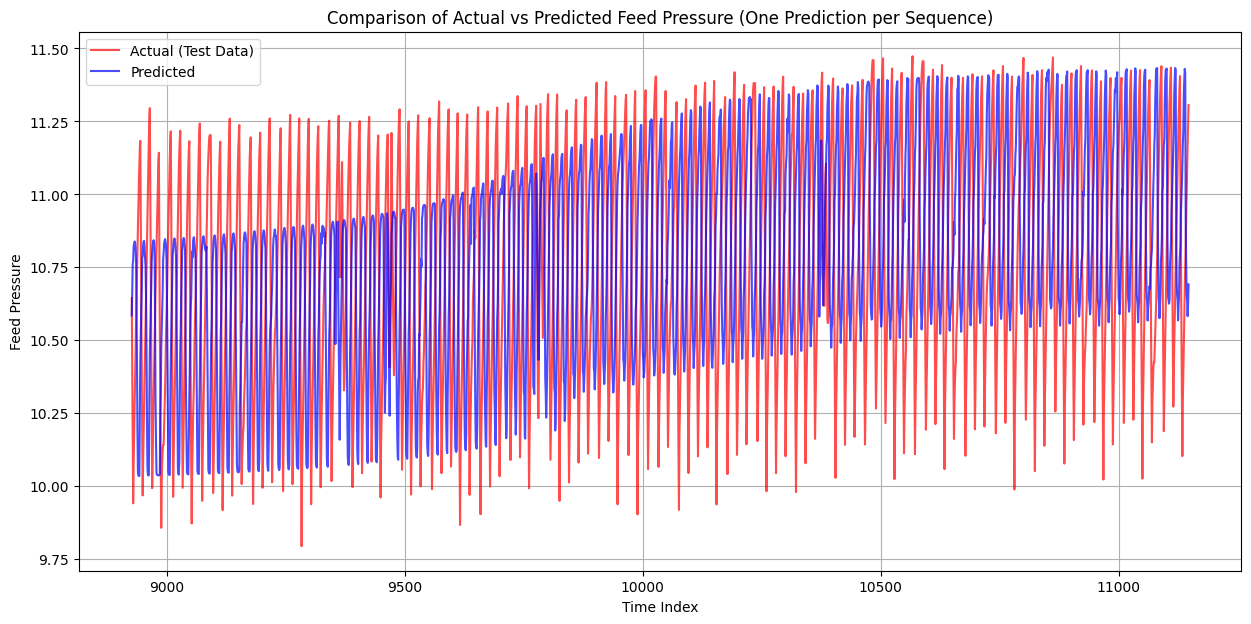

In [8]:
# 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib pytorch-lightning pytorch-forecasting

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from torch.optim import Adam
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 병합 후 크기 확인
df_total = pd.concat([df_train, df_test], ignore_index=True)
print(f"Total time_idx range: {df_total['time_idx'].min()} to {df_total['time_idx'].max()}")

# 학습 데이터셋 정의
max_encoder_length = 10  # 입력 시퀀스 길이
max_prediction_length = 1  # 한 시퀀스에서 하나의 값만 예측

df_total["group"] = "series"  # 단일 시계열 그룹

training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화 변수를 추가
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=RMSE()
)

# TFT 모델을 LightningModule로 감싸기 위한 클래스 정의
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

# TFT 모델을 TFTWrapper로 감싸기
wrapped_tft = TFTWrapper(tft)

# Trainer 설정
trainer = Trainer(
    accelerator="cpu",  # GPU 사용 시 'gpu'로 변경
    devices=1,
    max_epochs=2,
    gradient_clip_val=0.1
)

# 모델 학습
trainer.fit(
    model=wrapped_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

# 테스트 데이터셋 정의
test_dataset = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx >= len(df_train)],  # 테스트 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,  # 한 시퀀스에서 하나만 예측
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화 변수를 추가
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 테스트 데이터 로더 생성
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

# 테스트 데이터셋에 대한 예측 수행
test_predictions = tft.predict(test_dataloader, mode="prediction", return_x=False)

# 예측값 복원
predicted_test = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# 실제값 복원
actual_test = scaler.inverse_transform(df_test["feed_pressure"].values.reshape(-1, 1)).flatten()

# 시간 인덱스 추출
test_time_idx = df_test["time_idx"].values

# 길이 조정
min_length = min(len(test_time_idx), len(actual_test), len(predicted_test))
test_time_idx = test_time_idx[:min_length]
print(f"Length of test_time_idx: {len(test_time_idx)}")
actual_test = actual_test[:min_length]
predicted_test = predicted_test[:min_length]

# 테스트 데이터 크기 확인
print(f"Length of df_test: {len(df_test)}")
print(f"Time index range of df_test: {df_test['time_idx'].min()} to {df_test['time_idx'].max()}")
print(f"Unique time_idx values: {len(set(test_time_idx))}")
print(f"Is time_idx sequential: {np.all(np.diff(test_time_idx) > 0)}")
# test_time_idx와 actual_test, predicted_test의 값 확인
print(test_time_idx[:10])  # 첫 10개 인덱스 확인
print(actual_test[:10])    # 첫 10개 실제값 확인
print(predicted_test[:10]) # 첫 10개 예측값
print(f"Actual test range: {actual_test.min()} to {actual_test.max()}")
print(f"Predicted test range: {predicted_test.min()} to {predicted_test.max()}")

# 예측값 크기 확인
print(f"Length of test_predictions: {len(test_predictions)}")

# 시각화: 테스트 데이터와 비교
plt.figure(figsize=(15, 7))
plt.plot(test_time_idx, actual_test, label="Actual (Test Data)", color="red", alpha=0.7)
plt.plot(test_time_idx, predicted_test, label="Predicted", color="blue", alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("Feed Pressure")
plt.title("Comparison of Actual vs Predicted Feed Pressure (One Prediction per Sequence)")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Total time_idx range: 0 to 11157


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Length of test_time_idx: 1732
Length of actual_test: 1732
Length of predicted_test: 1732
Length of future_time_idx: 1500
Length of predicted_future: 1500


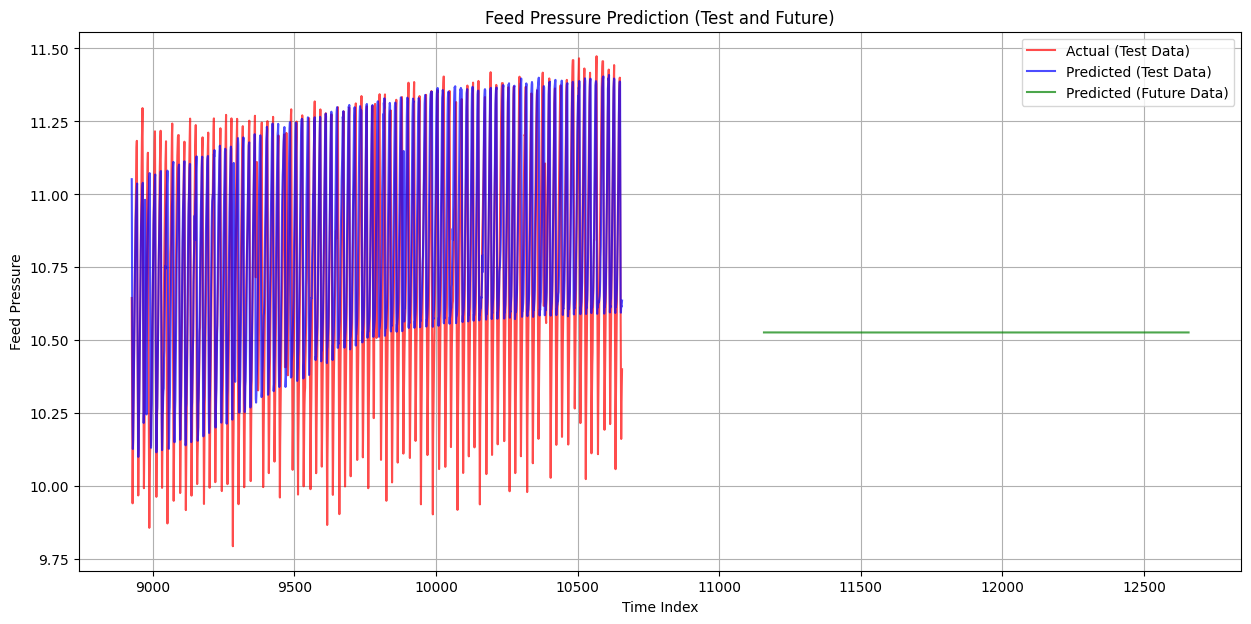

In [14]:
# 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib pytorch-lightning pytorch-forecasting

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer
from torch.optim import Adam
import pytorch_lightning as pl

# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 병합 후 크기 확인
df_total = pd.concat([df_train, df_test], ignore_index=True)
print(f"Total time_idx range: {df_total['time_idx'].min()} to {df_total['time_idx'].max()}")

# 학습 데이터셋 정의
max_encoder_length = 500  # 입력 시퀀스 길이
max_prediction_length = 1  # 한 시퀀스에서 하나의 값만 예측

df_total["group"] = "series"  # 단일 시계열 그룹

training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화 변수를 추가
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=RMSE()
)

# TFT 모델을 LightningModule로 감싸기 위한 클래스 정의
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

# TFT 모델을 TFTWrapper로 감싸기
wrapped_tft = TFTWrapper(tft)

# Trainer 설정
trainer = Trainer(
    accelerator="cpu",  # GPU 사용 시 'gpu'로 변경
    devices=1,
    max_epochs=2,
    gradient_clip_val=0.1
)

# 모델 학습
trainer.fit(
    model=wrapped_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

# 테스트 데이터셋 정의
test_dataset = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx >= len(df_train)],  # 테스트 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,  # 한 시퀀스에서 하나만 예측
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화 변수를 추가
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 테스트 데이터 로더 생성
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

# 테스트 데이터셋에 대한 예측 수행
test_predictions = tft.predict(test_dataloader, mode="prediction", return_x=False)

# 예측값 복원
predicted_test = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# 실제값 복원
actual_test = scaler.inverse_transform(df_test["feed_pressure"].values.reshape(-1, 1)).flatten()

# 시간 인덱스 추출
test_time_idx = df_test["time_idx"].values

# 추가 2000개의 미래 시퀀스 예측
future_time_idx = np.arange(test_time_idx[-1] + 1, test_time_idx[-1] + 2001)
# 미래 데이터 생성
future_data = pd.DataFrame({
    "time_idx": future_time_idx,
    "group": "series",
    "feed_pressure": np.nan
})

# 미래 데이터에서 feed_pressure 값을 이전 데이터의 마지막 값으로 채우기
last_known_value = df_total.loc[df_total['feed_pressure'].last_valid_index(), 'feed_pressure']
future_data['feed_pressure'] = last_known_value

# 기존 데이터와 병합
df_future_total = pd.concat([df_total, future_data], ignore_index=True)

# 미래 데이터셋 정의
future_dataset = TimeSeriesDataSet(
    df_future_total[lambda x: x.time_idx >= test_time_idx[-1] + 1],  # 미래 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["feed_pressure"],
    target_normalizer=GroupNormalizer(transformation="relu")
)

future_dataloader = future_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

# 예측 수행
future_predictions = tft.predict(future_dataloader, mode="prediction", return_x=False)

# 예측값 복원
predicted_future = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

# 최소 길이로 배열 자르기
min_length = min(len(test_time_idx), len(predicted_test))
test_time_idx = test_time_idx[:min_length]
actual_test = actual_test[:min_length]
predicted_test = predicted_test[:min_length]

# 데이터 크기 확인
print(f"Length of test_time_idx: {len(test_time_idx)}")
print(f"Length of actual_test: {len(actual_test)}")
print(f"Length of predicted_test: {len(predicted_test)}")

# future_time_idx와 predicted_future의 최소 길이를 기준으로 자르기
min_future_length = min(len(future_time_idx), len(predicted_future))
future_time_idx = future_time_idx[:min_future_length]
predicted_future = predicted_future[:min_future_length]

# 데이터 크기 확인
print(f"Length of future_time_idx: {len(future_time_idx)}")
print(f"Length of predicted_future: {len(predicted_future)}")

# 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(test_time_idx, actual_test, label="Actual (Test Data)", color="red", alpha=0.7)
plt.plot(test_time_idx, predicted_test, label="Predicted (Test Data)", color="blue", alpha=0.7)
plt.plot(future_time_idx, predicted_future, label="Predicted (Future Data)", color="green", alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("Feed Pressure")
plt.title("Feed Pressure Prediction (Test and Future)")
plt.legend()
plt.grid(True)
plt.show()

